# Analysis of 100 abstracts from development set

Tong Shu Li<br>
Created on: 2015-08-26<br>
Last updated: 2015-08-26

Jobs 771158 and 771159 were used to run the 100 abstracts from the development set in the same manner as the 500 abstracts from the evaluation set. Here we will look at how well the crowd did.

In [1]:
from collections import defaultdict
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
matplotlib inline

In [3]:
from src.filter_data import filter_data
from src.data_model import parse_input
from src.data_model import Relation
from src.data_model import is_MeSH_id
from src.get_AUC_value import get_AUC_value
from src.F_score import *
from src.aggregate_results import *

In [4]:
from src.lingpipe.file_util import read_file

---

In [5]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development"]
    assert file_format in ["list", "dict"]
    
    fname = "data/gold_standard/parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    if os.path.exists(fname):
        print("Reading cached version of {0} set ({1})".format(dataset, file_format))
        
        with open(fname, "rb") as fin:
            data = pickle.load(fin)
    else:
        print("Parsing raw {0} file".format(dataset))
        data = parse_input("data/gold_standard".format(dataset),
                           "CDR_{0}Set.txt".format(dataset.capitalize()),
                           is_gold = True,
                           return_format = file_format,
                          fix_acronyms = False)
        
        with open(fname, "wb") as fout:
            pickle.dump(data, fout)
            
    return data

In [6]:
dev_gold = read_gold_standard("development", "dict")

Reading cached version of development set (dict)


In [7]:
def in_gold(row):
    pmid = int(row["pmid"])
    return int(dev_gold[pmid].has_relation(Relation(pmid, row["chemical_id"], row["disease_id"])))

### Read the tmChem/DNorm processed testset

In [8]:
dev_testset = parse_input("data/devset_100_test", "processed_CDR_devset.txt",
                         is_gold = False, return_format = "dict", fix_acronyms = True)

In [9]:
len(dev_testset.keys())

100

In [10]:
testset_pmids = set(dev_testset.keys())

In [11]:
testset_pmids

{33969,
 326460,
 803783,
 982002,
 1423339,
 1535072,
 1564236,
 1595783,
 1610717,
 1628552,
 1969772,
 2004015,
 2257294,
 2322844,
 2598570,
 2826064,
 2894433,
 2917114,
 3088349,
 3300918,
 3311455,
 3703509,
 3708922,
 3969369,
 3973521,
 6111982,
 6118280,
 6150641,
 6454943,
 6496797,
 6892185,
 7437994,
 7542793,
 7650771,
 7651879,
 7710775,
 7803371,
 7880714,
 8111719,
 8267029,
 8305357,
 8424298,
 8480959,
 8492347,
 8586822,
 8686832,
 8800187,
 9041081,
 9098464,
 9201797,
 9270571,
 9564988,
 9636837,
 9669632,
 9875685,
 10225068,
 10328196,
 10523326,
 10565806,
 10743694,
 10840460,
 10910842,
 11063349,
 11077455,
 11282081,
 11337188,
 11524350,
 11704023,
 11705128,
 11860278,
 11868798,
 11999899,
 12448656,
 12452237,
 12911170,
 15096016,
 15266215,
 15266362,
 15565293,
 15811908,
 15858223,
 15893386,
 16174948,
 16192988,
 16225977,
 16471092,
 16596970,
 17682013,
 18006530,
 18356633,
 18483878,
 18657397,
 19135948,
 19370593,
 19761039,
 20042557,
 204

### Look at how well the NER performed:

In [12]:
def ner_results(program_output, gold_data):
    TP = 0
    FP = 0
    num_concepts = 0
    
    pmids = program_output.keys()
    
    assert set(pmids).issubset(set(gold_data.keys()))
    
    for pmid, paper in program_output.items():
        gold_paper = gold_data[pmid]
        
        tp = 0
        fp = 0
        for prog_annot in paper.annotations:
            for gold_annot in gold_paper.annotations:
                if (prog_annot.start == gold_annot.start
                   and prog_annot.stop == gold_annot.stop):
                    
                    assert prog_annot.text == gold_annot.text
                    assert prog_annot.stype == gold_annot.stype
                

                    p = {v for v in prog_annot.uid if v.uid_type == "MESH"}
                    g = {v for v in gold_annot.uid if v.uid_type == "MESH"}

                    if p == g:
                        tp += 1
                    else:
                        fp += 1
                        
        num_concepts += len(gold_paper.annotations)
                
        TP += tp
        FP += fp
        
    recall = TP / num_concepts
    precision = TP / (TP + FP)
    
    f_score = 2 * precision * recall / (precision + recall)
    
    print("F score:", f_score)

    print("recall: {0}".format(recall))
    print("precision: {0}".format(precision))

    print("TP: {0}".format(TP))
    print("FP: {0}".format(FP))
    print("# of gold std annotations: {0}".format(num_concepts))

In [13]:
ner_results(dev_testset, dev_gold)

F score: 0.922762148337596
recall: 0.9069884364002011
precision: 0.9390942217595003
TP: 1804
FP: 117
# of gold std annotations: 1989


---

### Look at abstract-level task

In [14]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_771158_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

abs_work_raw_data = filter_data(settings)

In [15]:
abs_work_raw_data.shape

(2700, 30)

In [16]:
abs_work_raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,disease_id,disease_name,form_abstract,form_title,old_cf_work_unit_id,original_job_id,pmid,uniq_id,verify_relationship_gold,verify_relationship_gold_reason
1381,778101077,8/26/2015 05:16:59,False,1721349910,NaN,8/26/2015 05:15:54,False,neodev,0.9091,27790533,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1382,778101077,8/26/2015 05:18:02,False,1721350185,NaN,8/26/2015 05:16:52,False,clixsense,1.0000,17209680,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1383,778101077,8/26/2015 05:21:32,False,1721351833,NaN,8/26/2015 05:16:52,False,neodev,0.8400,33870718,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1384,778101077,8/26/2015 05:22:09,False,1721352160,NaN,8/26/2015 05:16:24,False,neodev,0.9231,33498392,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1385,778101077,8/26/2015 05:23:38,False,1721353023,NaN,8/26/2015 05:16:40,False,clixsense,0.8000,17652709,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN


In [17]:
abs_work_raw_data["_tainted"].value_counts()

False    2700
dtype: int64

In [18]:
abs_work_raw_data["verify_relationship"].value_counts(normalize = True)

no_relation    0.716667
yes_direct     0.283333
dtype: float64

In [19]:
def judgments(dataframe):
    votes = defaultdict(set)
    for uniq_id, group in dataframe.groupby("uniq_id"):
        votes[len(group["_worker_id"].unique())].add(uniq_id)

    for vote, units in votes.items():
        print("Judgements {0}, # of work units: {1}".format(vote, len(units)))

In [20]:
judgments(abs_work_raw_data)

Judgements 5, # of work units: 540


### Abstract-task result aggregation

In [21]:
abs_res = aggregate_results("uniq_id", "verify_relationship", abs_work_raw_data,
                        "positive_signal_only",
                        ["pmid", "_unit_id", "chemical_id", "disease_id"],
                        "yes_direct")

In [22]:
abs_res.shape

(1046, 9)

In [23]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id
1,bcv_devset_test_100_hard_0,yes_direct,0.9091,1,0.203278,9669632,778101077,MESH:D020117,MESH:D015746
0,bcv_devset_test_100_hard_0,no_relation,3.5631,4,0.796722,9669632,778101077,MESH:D020117,MESH:D015746
1,bcv_devset_test_100_hard_1,yes_direct,1.9091,2,0.423201,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_1,no_relation,2.6020,3,0.576799,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_10,yes_direct,0.0000,0,0.000000,7880714,778101087,MESH:D002045,MESH:D006311


In [24]:
abs_res = abs_res.query("verify_relationship == 'yes_direct'")

In [25]:
abs_res.shape

(540, 9)

In [26]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id
1,bcv_devset_test_100_hard_0,yes_direct,0.9091,1,0.203278,9669632,778101077,MESH:D020117,MESH:D015746
1,bcv_devset_test_100_hard_1,yes_direct,1.9091,2,0.423201,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_10,yes_direct,0.0000,0,0.000000,7880714,778101087,MESH:D002045,MESH:D006311
0,bcv_devset_test_100_hard_100,yes_direct,0.0000,0,0.000000,19370593,778101177,MESH:D011372,MESH:D002318
0,bcv_devset_test_100_hard_101,yes_direct,0.0000,0,0.000000,19370593,778101178,MESH:D011372,MESH:D050723


In [27]:
abs_res = abs_res.rename(columns = {"percent_agree":"norm_conf_score"})

---

### Sentence task:

In [28]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_771159_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

sent_raw_data = filter_data(settings)

In [29]:
sent_raw_data.shape

(3300, 30)

In [30]:
sent_raw_data["_tainted"].value_counts()

False    3245
True       55
dtype: int64

In [31]:
sent_raw_data = sent_raw_data.query("~_tainted")

In [32]:
sent_raw_data.shape

(3245, 30)

In [33]:
# take positive votes only, indirect is no
sent_lvl_res = aggregate_results("uniq_id", "verify_relationship",
                                 sent_raw_data, "positive_signal_only",
                                 ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"],
                                 "yes_direct", {"yes_indirect" : "no_relation"})

In [34]:
sent_lvl_res.shape

(1159, 11)

In [35]:
sent_lvl_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
1,bcv_devset_test_100_easy_0,yes_direct,1.7002,2,0.367611,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
0,bcv_devset_test_100_easy_0,no_relation,2.9248,3,0.632389,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
1,bcv_devset_test_100_easy_1,yes_direct,1.7002,2,0.378875,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
0,bcv_devset_test_100_easy_1,no_relation,2.7873,3,0.621125,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
1,bcv_devset_test_100_easy_10,yes_direct,1.8824,2,0.407808,9669632,778102235,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_9


In [36]:
sent_lvl_res = sent_lvl_res.query("verify_relationship == 'yes_direct'")

In [37]:
sent_lvl_res.shape

(649, 11)

In [38]:
sent_lvl_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
1,bcv_devset_test_100_easy_0,yes_direct,1.7002,2,0.367611,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
1,bcv_devset_test_100_easy_1,yes_direct,1.7002,2,0.378875,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
1,bcv_devset_test_100_easy_10,yes_direct,1.8824,2,0.407808,9669632,778102235,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_9
0,bcv_devset_test_100_easy_100,yes_direct,4.2931,5,1.000000,17682013,778102325,MESH:D008727,MESH:D056784,17682013_MESH:D008727_MESH:D056784,17682013_6
1,bcv_devset_test_100_easy_101,yes_direct,3.6849,4,0.815929,17682013,778102326,MESH:D005472,MESH:D056784,17682013_MESH:D005472_MESH:D056784,17682013_6


### Aggregate at abstract level

In [39]:
def aggregate_sentences(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        assert len(group["relation_pair_id"].unique()) == 1
        norm_conf_score_max = group["percent_agree"].max()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["num_votes"].append(group["num_votes"].max())
        res["norm_conf_score"].append(norm_conf_score_max)
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        res["sentence_ids"].append("|".join(group["sentence_id"].unique()))
        
    return pd.DataFrame(res)

In [40]:
sent_perf_abs = aggregate_sentences(sent_lvl_res)

In [41]:
sent_perf_abs.shape

(426, 8)

In [42]:
sent_perf_abs.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,sentence_ids,uniq_ids,unit_ids
0,MESH:C017610,MESH:D010302,0.609304,3,33969,33969_1,bcv_devset_test_100_easy_279,778102504
1,MESH:C017610,MESH:D012559,0.000000,0,33969,33969_1,bcv_devset_test_100_easy_275,778102500
2,MESH:C084820,MESH:D001008,0.815284,4,33969,33969_3,bcv_devset_test_100_easy_285,778102510
3,MESH:C084820,MESH:D003866,0.225109,1,33969,33969_3,bcv_devset_test_100_easy_283,778102508
4,MESH:C084820,MESH:D004409,0.000000,0,33969,33969_3,bcv_devset_test_100_easy_284,778102509


In [43]:
with open("data/devset_100_test/devset_100_cid_relations.pickle", "rb") as fin:
    cid_relations = pickle.load(fin)

### Putting everything together

In [44]:
def flat_repr(id_set):
    vals = ["{0}:{1}".format(v.uid_type, v.uid) for v in id_set]
    return "|".join(sorted(vals))

In [45]:
def get_data(dataframe, pmid):
    temp = dataframe.query("pmid == {0}".format(pmid))
    if temp.empty:
        return "empty"
    
    return temp[["pmid", "chemical_id", "disease_id", "norm_conf_score", "num_votes"]]

def get_final_res(sent_res, abs_res, datamodel):
    final_ans = []
    for pmid in testset_pmids:
        this_paper_rels = []
        
        # abstract relations
        temp = get_data(abs_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "abstract_task"
            this_paper_rels.append(temp)
            
        # sentence relations
        temp = get_data(sent_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "sentence_task"
            this_paper_rels.append(temp)
            
        things = defaultdict(list)
        paper_cid_rels = datamodel[pmid].poss_relations["CID"]
        if paper_cid_rels: # not empty
            for cid_relation in paper_cid_rels:
                things["pmid"].append(pmid)
                things["chemical_id"].append(flat_repr(cid_relation[0]))
                things["disease_id"].append(flat_repr(cid_relation[1]))
                things["norm_conf_score"].append(1)
                things["num_votes"].append(5)
                things["rel_origin"].append("cid_relation")
                
            this_paper_rels.append(pd.DataFrame(things))
            
        if len(this_paper_rels) > 0:
            # some papers have no detectable relations (eg, pmid 250)
            final_ans.append(pd.concat(this_paper_rels))
        
    return pd.concat(final_ans)

In [46]:
for pmid, paper in dev_testset.items():
    assert paper.poss_relations["CID"] == cid_relations[pmid]

In [47]:
final_res = get_final_res(sent_perf_abs, abs_res, dev_testset)

In [48]:
final_res

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
1,MESH:D020117,MESH:D015746,0.203278,1,9669632,abstract_task
1,MESH:D020117,MESH:D005767,0.423201,2,9669632,abstract_task
212,MESH:D020117,MESH:D003248,0.212550,1,9669632,sentence_task
213,MESH:D020117,MESH:D003967,0.377915,2,9669632,sentence_task
214,MESH:D020117,MESH:D010146,1.000000,5,9669632,sentence_task
215,MESH:D020117,MESH:D043183,0.568115,3,9669632,sentence_task
1,MESH:C117268,MESH:D003875,0.577846,3,20466178,abstract_task
1,MESH:C117268,MESH:D012393,0.792744,4,20466178,abstract_task
0,MESH:D016559,MESH:D013684,1.000000,5,20466178,abstract_task
0,MESH:C117268,MESH:D013684,1.000000,5,20466178,abstract_task


In [49]:
final_res["in_gold"] = final_res.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [50]:
final_res

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin,in_gold
1,MESH:D020117,MESH:D015746,0.203278,1,9669632,abstract_task,1
1,MESH:D020117,MESH:D005767,0.423201,2,9669632,abstract_task,0
212,MESH:D020117,MESH:D003248,0.212550,1,9669632,sentence_task,0
213,MESH:D020117,MESH:D003967,0.377915,2,9669632,sentence_task,0
214,MESH:D020117,MESH:D010146,1.000000,5,9669632,sentence_task,0
215,MESH:D020117,MESH:D043183,0.568115,3,9669632,sentence_task,0
1,MESH:C117268,MESH:D003875,0.577846,3,20466178,abstract_task,1
1,MESH:C117268,MESH:D012393,0.792744,4,20466178,abstract_task,0
0,MESH:D016559,MESH:D013684,1.000000,5,20466178,abstract_task,0
0,MESH:C117268,MESH:D013684,1.000000,5,20466178,abstract_task,1


In [51]:
max_F_score("norm_conf_score", "in_gold", final_res)

F_score      0.637209
precision    0.545817
recall       0.765363
threshold    0.789366
Name: 369, dtype: float64

In [52]:
max_F_score("num_votes", "in_gold", final_res)

F_score      0.625571
precision    0.528958
recall       0.765363
threshold    4.000000
Name: 4, dtype: float64

In [53]:
fname = "data/roc/dev_testset_100_abstracts_total_res.png"
title = "ROC for 100 development set abstracts with indirect votes meaning no, norm_conf_score"
get_AUC_value(final_res, "norm_conf_score", "in_gold", fname, title)

0.8678053251207944

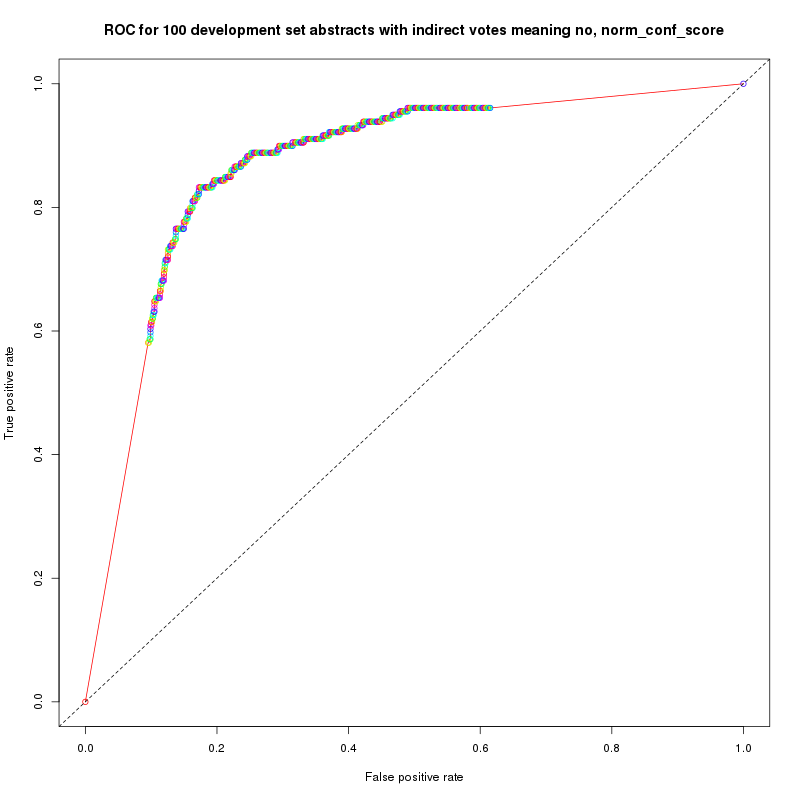

In [54]:
Image(fname)

In [55]:
fname = "data/roc/dev_testset_100_abstracts_total_res_votes.png"
title = "ROC for 100 development set abstracts with indirect votes meaning no, num_votes"
get_AUC_value(final_res, "num_votes", "in_gold", fname, title)

0.8633138128323146

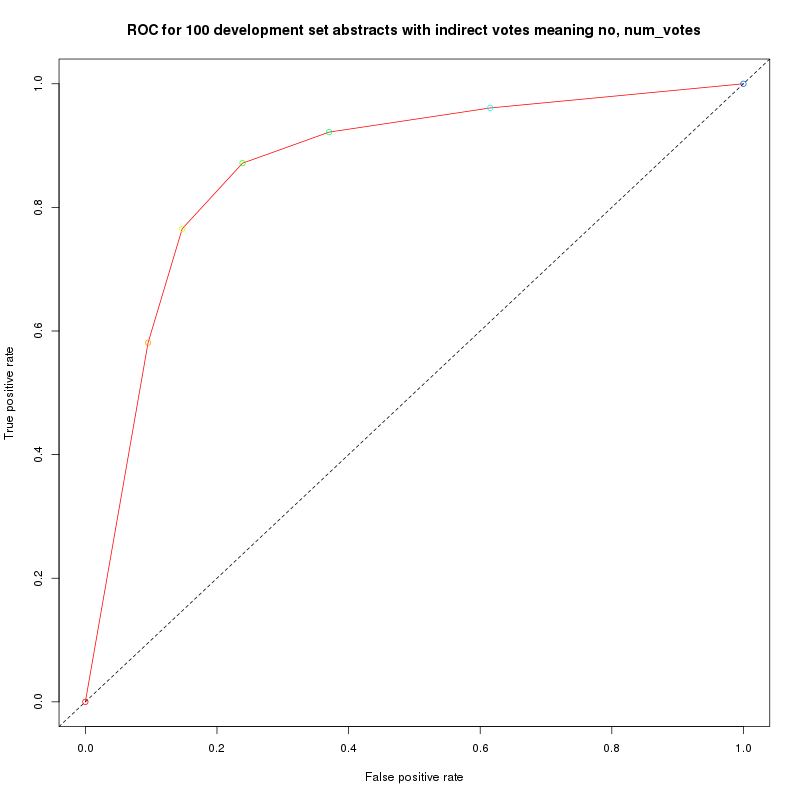

In [56]:
Image(fname)

In [57]:
def plot_results(score_column, class_column, dataframe):
    res = all_F_scores(score_column, class_column, dataframe)
    res = res.sort("threshold")
    
    graph = res.plot(x = "threshold", figsize = (7, 7))
    graph.set_ylim((0, 1.1))

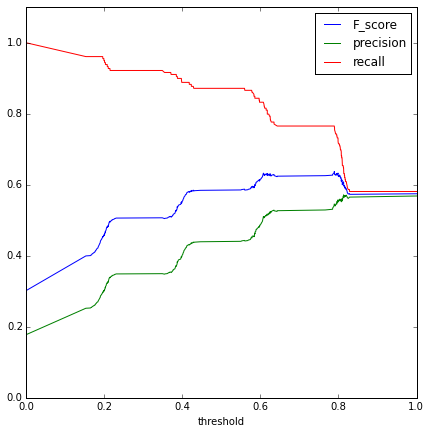

In [58]:
plot_results("norm_conf_score", "in_gold", final_res)

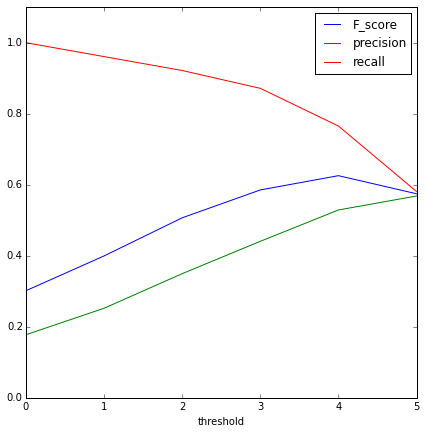

In [59]:
plot_results("num_votes", "in_gold", final_res)

### Evaluation using the official method

In [60]:
def simple_repr(id_set):
    assert len(id_set) == 1
    temp = sorted(list(id_set))
    return "|".join(temp)

small_gold = {pmid: paper for pmid, paper in dev_gold.items() if pmid in testset_pmids}

gold_relations = set()
for pmid, paper in small_gold.items():
    for rel in paper.gold_relations:
        rep = "{0}#{1}+{2}".format(pmid, simple_repr(rel.chemical_id), simple_repr(rel.disease_id))
        gold_relations |= set([rep])

In [61]:
len(small_gold)

100

In [62]:
gold_relations

{'10225068#MESH:D008012+MESH:D011128',
 '10328196#MESH:D020123+MESH:D019559',
 '10523326#MESH:D007854+MESH:D006973',
 '10565806#MESH:C076029+MESH:D001714',
 '10743694#MESH:D016559+MESH:D000743',
 '10743694#MESH:D016559+MESH:D003922',
 '10743694#MESH:D016559+MESH:D005767',
 '10743694#MESH:D016559+MESH:D007674',
 '10743694#MESH:D016559+MESH:D008232',
 '10743694#MESH:D016559+MESH:D009202',
 '10743694#MESH:D016559+MESH:D011537',
 '10743694#MESH:D016559+MESH:D020258',
 '10743694#MESH:D016559+MESH:D056486',
 '10840460#MESH:D000171+MESH:D010146',
 '10840460#MESH:D003520+MESH:D003556',
 '10840460#MESH:D003520+MESH:D010146',
 '10910842#MESH:D011239+MESH:D009133',
 '10910842#MESH:D011239+MESH:D018908',
 '11063349#MESH:D016559+MESH:D007674',
 '11063349#MESH:D016572+MESH:D007674',
 '11077455#MESH:D020888+MESH:D014786',
 '11282081#MESH:D014700+MESH:D001281',
 '11337188#MESH:D000305+MESH:D018366',
 '11337188#MESH:D000305+MESH:D051437',
 '11337188#MESH:D010068+MESH:D018366',
 '11337188#MESH:D010068+M

In [63]:
def formater(s):
    if is_MeSH_id(s):
        return "MESH:{0}".format(s)
    
    assert s.startswith("MESH"), s
    assert is_MeSH_id(s.split(":")[1]), s
    return s

def get_list(s):
    return [formater(v) for v in s.split("|")]
    
def new_F_score(score_column, dataframe):
    EPSILON = 0.0000001
    
    res = defaultdict(list)
    for threshold in dataframe[score_column].unique():
        sub = dataframe.query("{0} > {1} or -{2} <= {0} - {1} <= {2}".format(score_column, threshold, EPSILON))
        
        guess_set = set()
        for idx, row in sub.iterrows():
            chem_id = row["chemical_id"]
            dise_id = row["disease_id"]
            pmid = row["pmid"]
            
            chem_id = get_list(chem_id)
            dise_id = get_list(dise_id)
            
            temp = []
            for cid in chem_id:
                for did in dise_id:
                    temp.append("{0}#{1}+{2}".format(int(pmid), cid, did))
                    
            guess_set |= set(temp)                    
                
        tp = len(gold_relations & guess_set)
        fp = len(guess_set - gold_relations)
        fn = len(gold_relations - guess_set)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f_score = F_score(precision, recall)
        
        res["recall"].append(recall)
        res["precision"].append(precision)
        res["threshold"].append(threshold)
        res["F_score"].append(f_score)
        
    return pd.DataFrame(res)

In [64]:
official_res = new_F_score("norm_conf_score", final_res)

In [65]:
official_res.sort("F_score", ascending = False).head()

,F_score,precision,recall,threshold
369,0.598253,0.545817,0.661836,0.789366
38,0.597194,0.510274,0.719807,0.607823
166,0.596950,0.543651,0.661836,0.789359
361,0.596000,0.508532,0.719807,0.607743
23,0.595652,0.541502,0.661836,0.788715


In [66]:
official_res_vote = new_F_score("num_votes", final_res)

In [67]:
official_res_vote.sort("F_score", ascending = False)

,F_score,precision,recall,threshold
4,0.587983,0.528958,0.661836,4
3,0.554174,0.438202,0.753623,3
2,0.533333,0.568306,0.502415,5
1,0.483871,0.347368,0.797101,2
0,0.385650,0.251095,0.830918,1
5,0.293683,0.176877,0.864734,0


In [71]:
official_res_vote.sort("threshold", ascending = False)

,F_score,precision,recall,threshold
2,0.533333,0.568306,0.502415,5
4,0.587983,0.528958,0.661836,4
3,0.554174,0.438202,0.753623,3
1,0.483871,0.347368,0.797101,2
0,0.385650,0.251095,0.830918,1
5,0.293683,0.176877,0.864734,0


In [68]:
def plot_it(res):
    res = res.sort("threshold")

    graph = res.plot(x = "threshold", figsize = (7, 7))
    graph.set_ylim((0, 1.1))

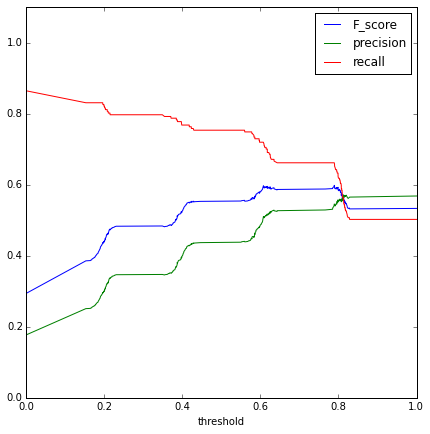

In [69]:
plot_it(official_res)

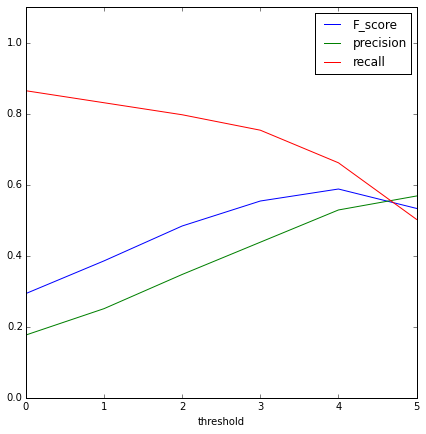

In [70]:
plot_it(official_res_vote)